In [40]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from problem_formulation import get_model_for_problem_formulation
from ema_workbench import (
    Policy,
    ema_logging,
    MultiprocessingEvaluator,
)

In [41]:
ema_logging.log_to_stderr(ema_logging.INFO)

# choose problem formulation number, between 0-5
# each problem formulation has its own list of outcomes
dike_model, planning_steps = get_model_for_problem_formulation(3)

uncertainties = copy.deepcopy(dike_model.uncertainties)
levers = copy.deepcopy(dike_model.levers)

In [42]:
def get_do_nothing_dict():
    return {l.name: 0 for l in dike_model.levers}


policies = [
    Policy(
        "policy 1",
        **dict(
            get_do_nothing_dict(),
            **{"0_RfR 0": 1, "0_RfR 1": 1, "0_RfR 2": 1, "A.1_DikeIncrease 0": 5}
        )
    ),
    Policy(
        "policy 2",
        **dict(
            get_do_nothing_dict(),
            **{"4_RfR 0": 1, "4_RfR 1": 1, "4_RfR 2": 1, "A.5_DikeIncrease 0": 5}
        )
    ),
    Policy(
        "policy 3",
        **dict(
            get_do_nothing_dict(),
            **{"1_RfR 0": 1, "2_RfR 1": 1, "3_RfR 2": 1, "A.3_DikeIncrease 0": 5}
        )
    ),
]

In [43]:
# pass the policies list to EMA workbench experiment runs #`1`
n_scenarios = 50
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios, policies)

experiments, outcomes = results

[MainProcess/INFO] pool started with 16 workers
[MainProcess/INFO] performing 50 scenarios * 3 policies * 1 model(s) = 150 experiments
100%|████████████████████████████████████████| 150/150 [00:07<00:00, 19.62it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [44]:
print(pd.DataFrame(experiments))

     A.0_ID flood wave shape    A.1_Bmax A.1_Brate  A.1_pfail    A.2_Bmax  \
0                         78  285.175770      10.0   0.663627  287.040502   
1                         88  257.798402       1.5   0.487301  143.842268   
2                         21   99.042764       1.5   0.432543  110.777093   
3                        123  117.470388       1.0   0.621412  292.879802   
4                        131   83.934279       1.0   0.734962  273.952867   
..                       ...         ...       ...        ...         ...   
145                       12  149.019939      10.0   0.800738  323.259735   
146                       23   76.378994       1.5   0.118789  223.462009   
147                      118  243.123559      10.0   0.844836  256.103626   
148                       36  123.181017       1.0   0.312172  204.754553   
149                       90  305.686694       1.0   0.040115  316.479365   

    A.2_Brate  A.2_pfail    A.3_Bmax A.3_Brate  A.3_pfail  ...  \
0        

In [45]:
print(pd.DataFrame(outcomes))

     A.1 Total Costs  A.1_Expected Number of Deaths  A.2 Total Costs  \
0       5.397251e+07                       0.000000     1.715358e+07   
1       5.397251e+07                       0.000000     2.100999e+08   
2       5.397251e+07                       0.000000     6.215547e+06   
3       5.397251e+07                       0.000000     4.159331e+07   
4       5.397251e+07                       0.000000     3.678120e+07   
..               ...                            ...              ...   
145     0.000000e+00                       0.000000     8.068261e+07   
146     2.682127e+09                       1.673331     0.000000e+00   
147     0.000000e+00                       0.000000     5.862915e+07   
148     4.509484e+07                       0.027689     3.711978e+07   
149     2.810460e+09                       1.671659     0.000000e+00   

     A.2_Expected Number of Deaths  A.3 Total Costs  \
0                         0.018971     1.137248e+09   
1                        

Once our results obtained, we are able to analyse them using PRIM. First however, we need to clean our dataset as to exclude categorical parameters. Those parameters, such as wave height the various RfR parameters are only integers and thus cannot be represented with a range like other parameters.

[MainProcess/INFO] column model dropped from analysis because it has only one category
[MainProcess/INFO] 150 points remaining, containing 55 cases of interest
C:\Users\tangu\PycharmProjects\MBDB\.venv\lib\site-packages\ema_workbench\analysis\prim.py:1569: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  box_paste.loc[i, u] = paste_value
[MainProcess/INFO] mean: 1.0, mass: 0.16, coverage: 0.43636363636363634, density: 1.0 restricted_dimensions: 7


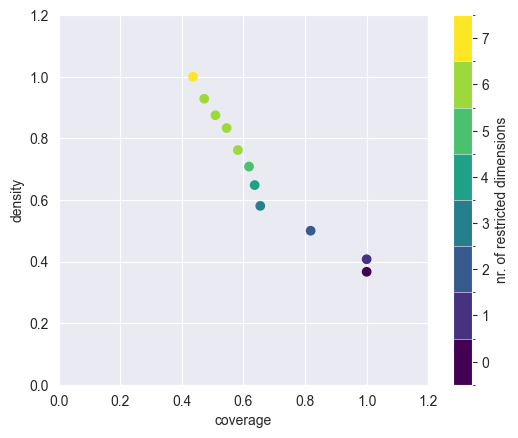

In [46]:
from ema_workbench.analysis import prim

df = pd.DataFrame(outcomes)
df_exp = pd.DataFrame(experiments)
x = df_exp
y= df['A.2 Total Costs']
y= y < 26042749

prim_alg = prim.Prim(x, y, threshold=0.8, peel_alpha= 0.1)
box1 = prim_alg.find_box()

box1.show_tradeoff()
plt.show()

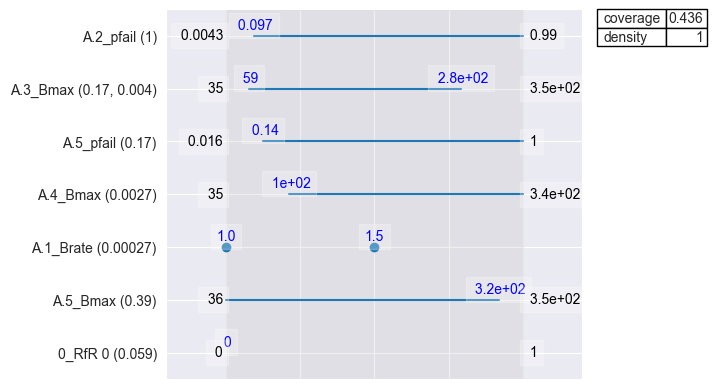

In [47]:
box1.inspect(style='graph')
plt.show()

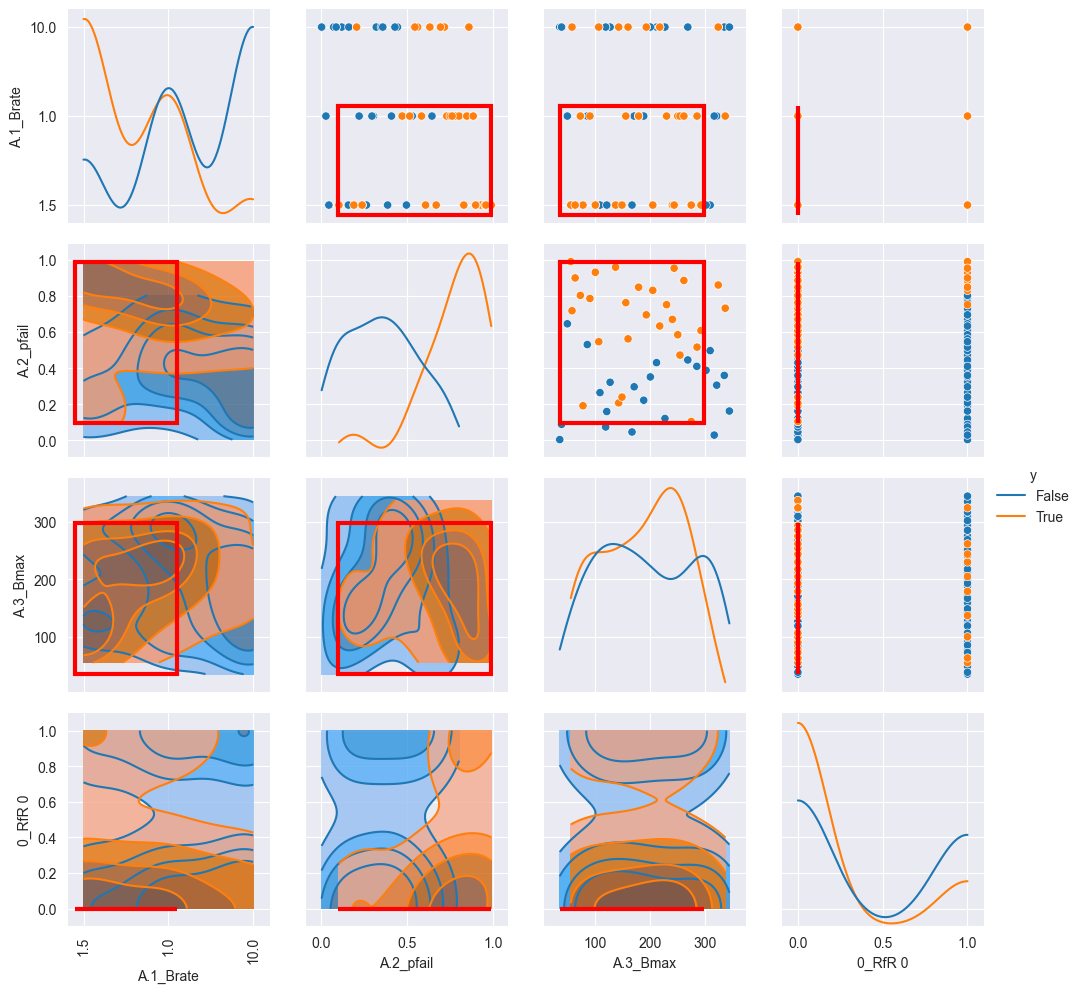

In [51]:

box1.show_pairs_scatter(4)
plt.show()

[MainProcess/INFO] model dropped from analysis because only a single category
C:\Users\tangu\PycharmProjects\MBDB\.venv\lib\site-packages\ema_workbench\analysis\dimensional_stacking.py:408: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pvt = pd.pivot_table(x_y_concat, values=ooi_label, index=rows, columns=columns, dropna=False)


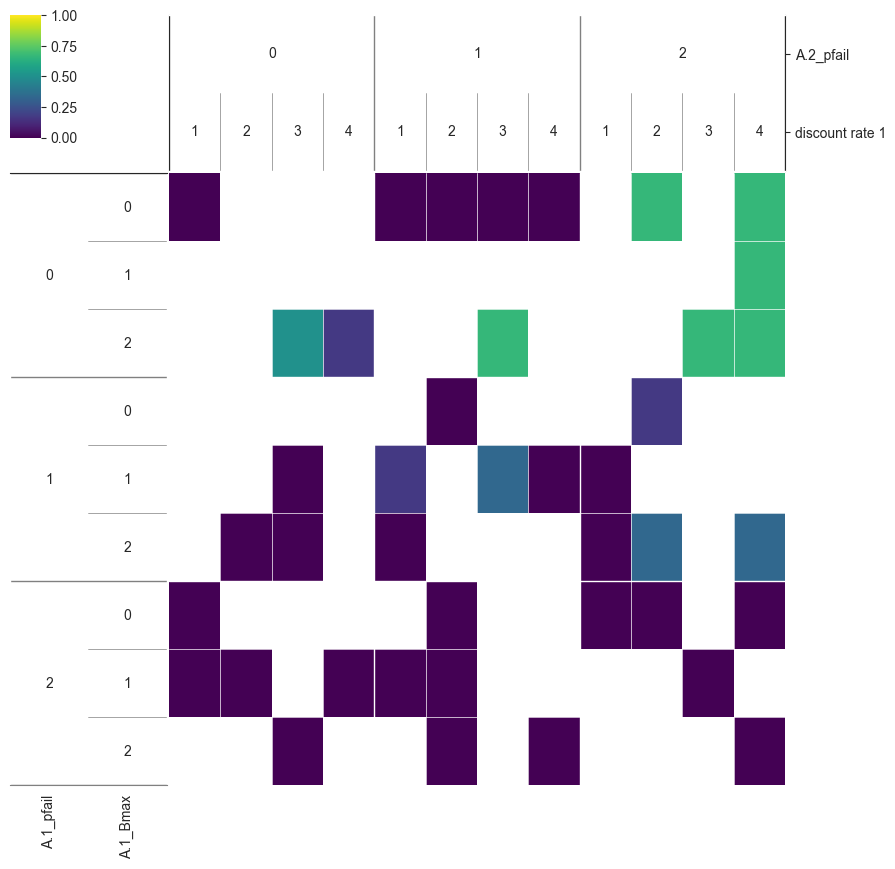

In [52]:
from ema_workbench.analysis import dimensional_stacking

x = experiments
y = outcomes["A.2 Total Costs"] < 200000
dimensional_stacking.create_pivot_plot(x, y, 2, nbins=3)
plt.show()

In [ ]:
from ema_workbench.analysis import regional_sa
from numpy.lib import recfunctions as rf

sns.set_style("white")

# model is the same across experiments
x = experiments.copy()
x = x.drop("model", axis=1)
y = outcomes["max_P"] < 0.8
fig = regional_sa.plot_cdfs(x, y)
sns.despine()
plt.show()